# Solar Generation Forecast

- Energy Traders making bets on renewable generation and its contribution to meeting energy demand.
- Day Ahead Planners in utilities preparing for or short-term planning horizons
- Calculating vital metrics such as Net Demand. I
- Initializing Power Flow simulation models

## Librairies

In [1]:
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
import plotly.express as px
import pvlib
import requests
import geocoder


## Dataset

In [2]:
# Specify the file path of the Excel file
file_path = 'CAISO Total Solar Historical Actuals.xlsx'

# Specify the sheet name
sheet_name = 'CAISO Total System Solar Power '

# Specify the range of cells you want to read (e.g., 'A1:C5')
cell_range = 'A3:C26196'

# Read the specified range in the specified sheet
data = pd.read_excel(file_path, sheet_name=sheet_name, header=2)
# df['Date'] = pd.to_datetime(df['Date'])

# Print the DataFrame
print(data)

            Date  Hour  Actual
0     2020-05-16     1       0
1     2020-05-16     2       0
2     2020-05-16     3       0
3     2020-05-16     4       0
4     2020-05-16     5       0
...          ...   ...     ...
26188 2023-05-14    20     874
26189 2023-05-14    21       0
26190 2023-05-14    22       3
26191 2023-05-14    23       7
26192 2023-05-14    24       6

[26193 rows x 3 columns]


## Explanatory Data Analysis

In [3]:
# Find duplicate records
duplicates = data.duplicated()
# Print the number of duplicate records
print('Number of duplicate records:', duplicates.sum())

Number of duplicate records: 5


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26193 entries, 0 to 26192
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    26193 non-null  datetime64[ns]
 1   Hour    26193 non-null  int64         
 2   Actual  26193 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 614.0 KB


In [5]:
data.isnull().sum()

Date      0
Hour      0
Actual    0
dtype: int64

In [6]:
# Combine the 'Date' and 'Hour' columns into a new column
data['DateHour'] = pd.to_datetime(data['Date']) + pd.to_timedelta(data['Hour'], unit='h')
print(data.head())

# Create a line plot using Plotly
fig = px.line(data, x='DateHour', y='Actual')

# Set the title and labels
fig.update_layout(title='Actual Values by Hour',
                  xaxis_title='Date and Hour',
                  yaxis_title='Actual Values')

# Rotate x-axis labels
fig.update_xaxes(tickangle=45)

# Display the plot
fig.show()

        Date  Hour  Actual            DateHour
0 2020-05-16     1       0 2020-05-16 01:00:00
1 2020-05-16     2       0 2020-05-16 02:00:00
2 2020-05-16     3       0 2020-05-16 03:00:00
3 2020-05-16     4       0 2020-05-16 04:00:00
4 2020-05-16     5       0 2020-05-16 05:00:00


In [7]:
# Create the line plot
fig = px.line(data, x='Hour', y='Actual', color='Date', title='Actual Values by Hour')

# Set the axis labels
fig.update_layout(xaxis_title='Hour', yaxis_title='Actual')

# Show the plot
fig.show()

In [8]:
# Reorder the columns
data = data.reindex(columns=['DateHour', 'Date', 'Hour', 'Actual'])

# Print the updated DataFrame
print(data)

                 DateHour       Date  Hour  Actual
0     2020-05-16 01:00:00 2020-05-16     1       0
1     2020-05-16 02:00:00 2020-05-16     2       0
2     2020-05-16 03:00:00 2020-05-16     3       0
3     2020-05-16 04:00:00 2020-05-16     4       0
4     2020-05-16 05:00:00 2020-05-16     5       0
...                   ...        ...   ...     ...
26188 2023-05-14 20:00:00 2023-05-14    20     874
26189 2023-05-14 21:00:00 2023-05-14    21       0
26190 2023-05-14 22:00:00 2023-05-14    22       3
26191 2023-05-14 23:00:00 2023-05-14    23       7
26192 2023-05-15 00:00:00 2023-05-14    24       6

[26193 rows x 4 columns]


## Retrieve Carlifornia region info

In [13]:
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut

# Function to retrieve altitude (elevation) based on latitude and longitude
def get_altitude(latitude, longitude):
    geolocator = Nominatim(user_agent='my-app')
    location = geolocator.reverse(f'{latitude}, {longitude}', exactly_one=True)
    if location.raw.get('elevation'):
        return location.raw['elevation']
    else:
        return None

# Specify the regions
regions = ['Northern California', 'Central California', 'Southern California']
# regions = 'California' #different results


# Create a geocoder instance
geolocator = Nominatim(user_agent='my-app')

# Initialize empty lists for latitude and longitude
latitudes = []
longitudes = []

# Loop through the regions and retrieve the coordinates
for region in regions:
    # Retrieve the location for the region
    location = geolocator.geocode(region)
    
    # Extract the latitude and longitude
    latitude = location.latitude
    longitude = location.longitude
    
    # Append the coordinates to the respective lists
    latitudes.append(latitude)
    longitudes.append(longitude)

# Calculate the average coordinates
avg_latitude = sum(latitudes) / len(latitudes)
avg_longitude = sum(longitudes) / len(longitudes)

# Print the average coordinates
print("Average Latitude:", avg_latitude)
print("Average Longitude:", avg_longitude)

# Retrieve the altitude (elevation) based on the latitude and longitude
# if get_altitude(latitude, longitude) == None: elevation = 0
# else: elevation = get_altitude(latitude, longitude)


# printing the address/location name
location = geolocator.reverse([avg_latitude, avg_longitude])
print(location.address)

Average Latitude: 37.05154843333334
Average Longitude: -120.6993705
CA 152;CA 33, Merced County, California, United States


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


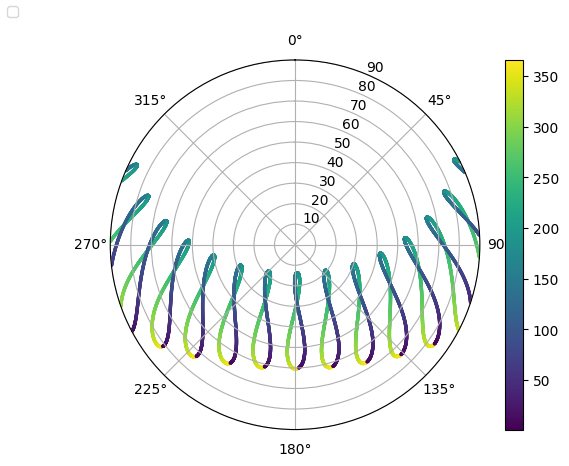

In [16]:
from pvlib import solarposition
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

tz = 'America/Los_Angeles'
lat, lon = avg_latitude, avg_longitude

times = pd.date_range(data['Date'].min(), data['Date'].max(), freq='H', tz=tz)
solpos = solarposition.get_solarposition(times, lat, lon)
# remove nighttime
solpos = solpos.loc[solpos['apparent_elevation'] > 0, :]

ax = plt.subplot(1, 1, 1, projection='polar')
# draw the analemma loops
points = ax.scatter(np.radians(solpos.azimuth), solpos.apparent_zenith,
                    s=2, label=None, c=solpos.index.dayofyear)
ax.figure.colorbar(points)

# # draw hour labels
# for hour in np.unique(solpos.index.hour):
#     # choose label position by the smallest radius for each hour
#     subset = solpos.loc[solpos.index.hour == hour, :]
#     r = subset.apparent_zenith
#     pos = solpos.loc[r.idxmin(), :]
#     ax.text(np.radians(pos['azimuth']), pos['apparent_zenith'], str(hour))

# # draw individual days
# for date in data['Date']:
#     times = pd.date_range(date, date+pd.Timedelta('24h'), freq='H', tz=tz)
#     solpos = solarposition.get_solarposition(times, lat, lon)
#     solpos = solpos.loc[solpos['apparent_elevation'] > 0, :]
#     label = date.strftime('%Y-%m-%d')
#     ax.plot(np.radians(solpos.azimuth), solpos.apparent_zenith, label=label)

ax.figure.legend(loc='upper left')

# change coordinates to be like a compass
ax.set_theta_zero_location('N')
ax.set_theta_direction(-1)
ax.set_rmax(90)

plt.show()

In [17]:
import plotly.graph_objects as go
import numpy as np
import pandas as pd
from pvlib import solarposition

tz = 'America/Los_Angeles'
lat, lon = avg_latitude, avg_longitude

times = pd.date_range(data['Date'].min(), data['Date'].max(), freq='H', tz=tz)
solpos = solarposition.get_solarposition(times, lat, lon)
solpos = solpos.loc[solpos['apparent_elevation'] > 0, :]

# Create the polar scatter plot
fig = go.Figure()

# Draw the analemma loops
fig.add_trace(go.Scatterpolar(
    r=solpos.apparent_zenith,
    theta=np.radians(solpos.azimuth),
    mode='markers',
    marker=dict(
        size=2,
        color=solpos.index.dayofyear,
        colorbar=dict(title='Day of Year'),
    ),
    name=None
))

# Draw hour labels
for hour in np.unique(solpos.index.hour):
    subset = solpos.loc[solpos.index.hour == hour, :]
    r = subset.apparent_zenith
    pos = solpos.loc[r.idxmin(), :]
    fig.add_trace(go.Scatterpolar(
        r=[pos['apparent_zenith']],
        theta=[np.radians(pos['azimuth'])],
        text=[str(hour)],
        mode='text',
        textposition='middle center',
        showlegend=False
    ))

# Draw individual days
for date in data['Date']:
    times = pd.date_range(date, date + pd.Timedelta('24h'), freq='H', tz=tz)
    solpos = solarposition.get_solarposition(times, lat, lon)
    solpos = solpos.loc[solpos['apparent_elevation'] > 0, :]
    label = date.strftime('%Y-%m-%d')
    fig.add_trace(go.Scatterpolar(
        r=solpos.apparent_zenith,
        theta=np.radians(solpos.azimuth),
        mode='lines',
        name=label
    ))

# Update the layout
fig.update_layout(
    polar=dict(
        radialaxis=dict(
            visible=True,
            range=[0, 90]
        ),
        angularaxis=dict(
            direction='clockwise',
            rotation=90
        )
    ),
    showlegend=True,
    title="Solar Position",
    width=800,
    height=800
)

# Show the plot
fig.show()
